In [32]:
import warnings
warnings.filterwarnings("ignore")

from fbprophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

from scipy import stats
import statsmodels.api as sm
from itertools import product
from datetime import timedelta

import pandas as pd
pd.options.display.max_columns = 999
import numpy as np

from sklearn.metrics import mean_squared_error
#RMSE = mean_squared_error(y, y_pred)**0.5

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

## Подготовка данных

In [130]:
df_price = pd.read_csv('data/player_price.csv')
df_stats = pd.read_csv('data/player_stats.csv')

df_price=df_price[df_price.player_id<=18320]
player_id=df_price.groupby(['player_id'])['xbox_price'].count()

df_price['Date'] = pd.to_datetime(df_price['timestamp'], unit='ms')
df_price.drop(['timestamp'], axis=1, inplace=True)
df_price.drop(['ps_price'],axis = 1, inplace=True)
df_price.rename(columns={'xbox_price':'price'}, inplace = True)

df_merge=df_stats[["player_id"]].merge(df_price, on=['player_id'], how='inner')


df_merge.shape

(966879, 4)

In [131]:
df_player=df_merge[df_merge.player_id==2145]
df_player.head()

,player_id,price,player_name,Date
350378,2145,4300,Dalbert,2016-09-23
350379,2145,0,Dalbert,2016-09-24
350380,2145,0,Dalbert,2016-09-25
350381,2145,0,Dalbert,2016-09-26
350382,2145,4500,Dalbert,2016-09-27


In [132]:
df=df_player[['Date','price']]
df=df.groupby('Date')[['price']].mean()
df=df.reset_index()
df.columns = ['ds', 'y']
#df=df.set_index('ds')
df=df.replace(0,int(df.mean()))

df.head()

,ds,y
0,2016-09-23,4300
1,2016-09-24,4993
2,2016-09-25,4993
3,2016-09-26,4993
4,2016-09-27,4500


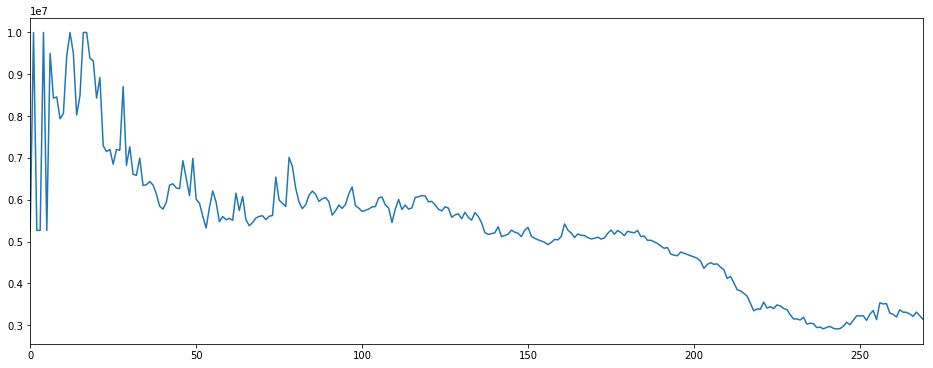

In [27]:
plt.figure(figsize=(16,6))
df['y'].plot()

In [133]:
train_df=df

In [112]:
#predictions = 7
train_df.head()

,ds,y
0,2017-01-04,27181
1,2017-01-05,14807
2,2017-01-06,16619
3,2017-01-07,13432
4,2017-01-08,13943


In [8]:
#train_df=df[:predictions]

In [134]:
m = Prophet()
m.fit(train_df)

Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [135]:
future = m.make_future_dataframe(periods=7)
future.tail(10)

,ds
270,2017-06-20
271,2017-06-21
272,2017-06-22
273,2017-06-23
274,2017-06-24
275,2017-06-25
276,2017-06-26
277,2017-06-27
278,2017-06-28
279,2017-06-29


In [136]:
forecast = m.predict(future)
forecast.tail()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,seasonal,yhat
275,2017-06-25,1.011029,6000.342166,-198.201259,-198.201259,6000.214876,6000.849311,3363.089849,8240.351426,-198.201259,-198.201259,-198.201259,-198.201259,5802.140907
276,2017-06-26,1.014706,6015.120378,-48.471973,-48.471973,6014.487697,6016.575422,3426.376558,8369.949691,-48.471973,-48.471973,-48.471973,-48.471973,5966.648405
277,2017-06-27,1.018382,6029.898589,223.170564,223.170564,6028.457506,6032.147737,3766.724674,8647.849888,223.170564,223.170564,223.170564,223.170564,6253.069153
278,2017-06-28,1.022059,6044.676800,384.110966,384.110966,6042.385271,6048.102906,3893.377089,9004.015513,384.110966,384.110966,384.110966,384.110966,6428.787766
279,2017-06-29,1.025735,6059.455012,75.480410,75.480410,6056.005804,6064.114033,3737.669403,8728.736309,75.480410,75.480410,75.480410,75.480410,6134.935422


In [44]:
print(', '.join(forecast.columns))

ds, t, trend, seasonal_lower, seasonal_upper, trend_lower, trend_upper, yhat_lower, yhat_upper, weekly, weekly_lower, weekly_upper, seasonal, yhat


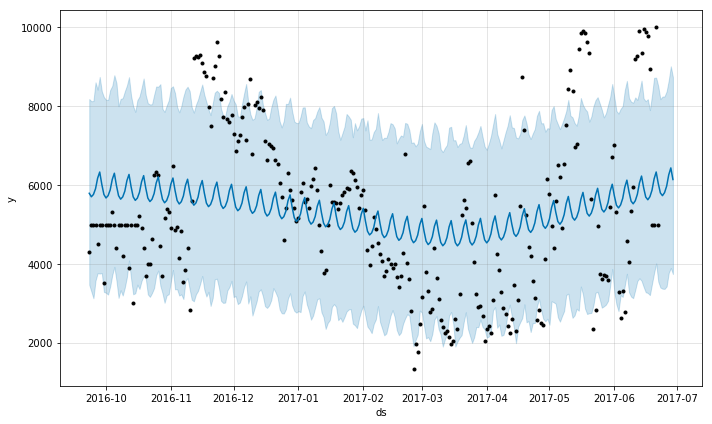

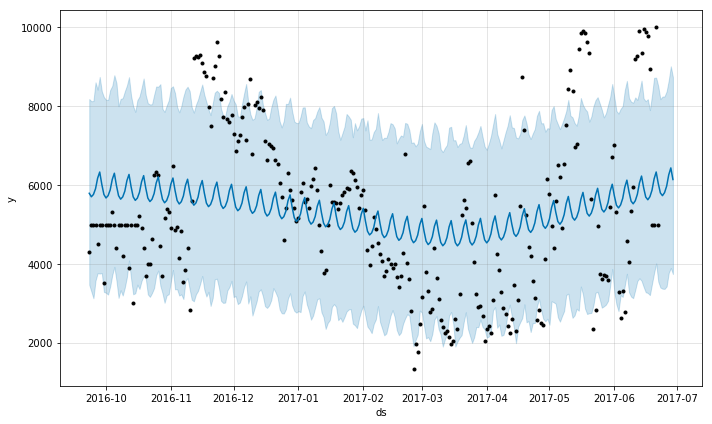

In [137]:
m.plot(forecast)

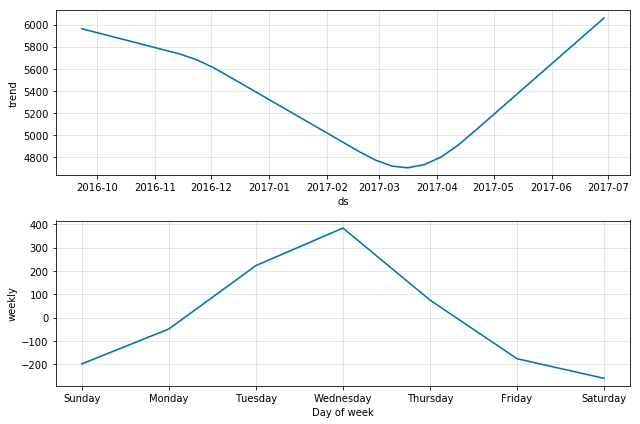

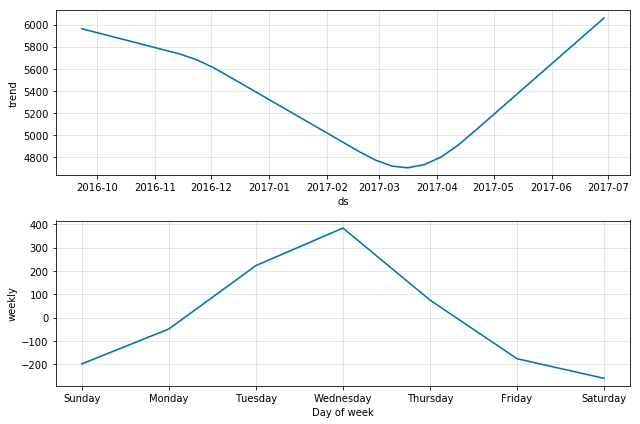

In [138]:
m.plot_components(forecast)

In [139]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [48]:
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE', np.mean(abs(cmp_df[-predictions:]['p'])))
print('MAE', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE nan
MAE nan


In [49]:
def show_forecast(cmp_df, num_predictions, num_values):

    forecast = go.Scatter(
        name='Prophet',
        x=cmp_df.tail(predictions).index,
        y=cmp_df.tail(predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )


    fact = go.Scatter(
        name='Fact',
        x=cmp_df.tail(num_values).index,
        y=cmp_df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines',
    )


    data = [forecast, fact]

    layout = go.Layout(
        yaxis=dict(title='price'),
        title='price',
        showlegend = True)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, predictions, 200)

In [140]:
cmp_df.tail(10)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2017-06-20,6149.621674,3766.199113,8711.468856,4993.0
2017-06-21,6325.340286,4008.843028,8715.668578,10000.0
2017-06-22,6031.487942,3547.274107,8497.677537,4993.0
2017-06-23,5794.845922,3397.392357,8170.156924,NaN
2017-06-24,5725.415068,3368.068313,8236.451039,NaN
2017-06-25,5802.140907,3363.089849,8240.351426,NaN
2017-06-26,5966.648405,3426.376558,8369.949691,NaN
2017-06-27,6253.069153,3766.724674,8647.849888,NaN
2017-06-28,6428.787766,3893.377089,9004.015513,NaN


In [141]:
qwe=cmp_df.yhat[-7:]
qwe

ds
2017-06-23    5794.845922
2017-06-24    5725.415068
2017-06-25    5802.140907
2017-06-26    5966.648405
2017-06-27    6253.069153
2017-06-28    6428.787766
2017-06-29    6134.935422
Name: yhat, dtype: float64

In [58]:
qwe.values

array([ 2824779.34569503,  2722624.46735832,  2798320.92821625,
        2688536.2193458 ,  2734230.08368164,  2601560.38876677,
        2531038.31278739,  2664950.40083381])

In [ ]:
qwe

In [196]:
df_price = pd.read_csv('data/player_price.csv')
df_stats = pd.read_csv('data/player_stats.csv')
sample_subm = pd.read_csv('data/kaggle_sample_submission.csv')

sample_subm["player_id"] = sample_subm["id"].apply(lambda x: int(x.split("_")[0]))
sample_subm["Date"] = sample_subm["id"].apply(lambda x: np.datetime64(x.split("_")[1]))

#player_id=df_price.groupby(['player_id'])['xbox_price'].count()
player_id=sample_subm.groupby(['player_id'])['price'].count()

#df_price=df_price[df_price.player_id<=18320]
df_price['Date'] = pd.to_datetime(df_price['timestamp'], unit='ms')
df_price.drop(['timestamp'], axis=1, inplace=True)
df_price.drop(['ps_price'],axis = 1, inplace=True)
df_price.rename(columns={'xbox_price':'price'}, inplace = True)

df_merge=df_stats[["player_id"]].merge(df_price, on=['player_id'], how='inner')

df_merge.shape

(980252, 4)

In [1]:
df_merge.tail()

NameError: name 'df_merge' is not defined

In [202]:
player_id.index

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            18336, 18337, 18338, 18339, 18340, 18341, 18342, 18344, 18345,
            18370],
           dtype='int64', name='player_id', length=1253)

In [9]:
# 1_2017-06-23 \ 1_2017-06-29
#15621 нет в dataset

In [195]:
len(player_id)

1253

In [203]:
#list(range(15621,15624))
#len(player_id)
player_id.index[1]

2

In [ ]:
%%time
k=0
for i in player_id.index:#player_id.index[732:len(player_id.index)]:#player_id.index:#range(1,6):
    print('==================================')
    print('id={}'.format(i))
    
    df_player=df_merge[df_merge.player_id==i]
        
    df=df_player[['Date','price']]
    df=df.groupby('Date')[['price']].mean()
    df=df.reset_index()
    df.columns = ['ds', 'y']
    #df=df.replace(0,int(df.mean()))
    df = df[df.y!=0]
    
    train_df=df
    
    #m = Prophet()
    m = Prophet(interval_width=0.95,mcmc_samples=500)
    m.fit(train_df)
    
    future = m.make_future_dataframe(periods=7)
    forecast = m.predict(future)
    
    cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
    
    qwe=cmp_df.yhat[-7:]    
    #print(qwe)
    
    pp=pd.DataFrame(columns=['id','price'])
    pp['id']=str(i)+'_'+qwe.index.astype(str)
    pp.price=qwe.values
    pp.price=pp.price.astype(int)
    print(pp)
    
    if k==0:
        pp.to_csv('prediction_fbpophet2.csv',sep=',',header=True,index=False)
        k=1
    else:
        with open('prediction_fbpophet2.csv', 'a') as f:
            pp.to_csv(f, header=False,index=False,sep=',')

id=1
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
             id    price
0  1_2017-06-23  2827680
1  1_2017-06-24  2764825
2  1_2017-06-25  2756080
3  1_2017-06-26  2689695
4  1_2017-06-27  2731826
5  1_2017-06-28  2756931
6  1_2017-06-29  2729186
id=2
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
             id   price
0  2_2017-06-23  616024
1  2_2017-06-24  590168
2  2_2017-06-25  573350
3  2_2017-06-26  568846
4  2_2017-06-27  568487
5  2_2017-06-28  557190
6  2_2017-06-29  562253
id=3
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
             id   price
0  3_2017-06-23  346938
1  3_2017-06-24  329543
2  3_2017-06-25  320316
3  3_2017-06-26  317618
4  3_2017-06-27  321237
5  3_2017-06-28  318097
6  3_2017-06-29  316119
id=4
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
             id   price
0  4_2017-06-23 

              id    price
0  26_2017-06-23  1393782
1  26_2017-06-24  1319360
2  26_2017-06-25  1303685
3  26_2017-06-26  1290850
4  26_2017-06-27  1282214
5  26_2017-06-28  1275596
6  26_2017-06-29  1275964
id=27
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
              id   price
0  27_2017-06-23  574034
1  27_2017-06-24  528448
2  27_2017-06-25  512278
3  27_2017-06-26  496860
4  27_2017-06-27  525371
5  27_2017-06-28  499688
6  27_2017-06-29  502398
id=28
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
              id   price
0  28_2017-06-23  111350
1  28_2017-06-24  113335
2  28_2017-06-25  106986
3  28_2017-06-26  102648
4  28_2017-06-27  104033
5  28_2017-06-28  101173
6  28_2017-06-29   98471
id=29
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
              id   price
0  29_2017-06-23  167745
1  29_2017-06-24  136215
2  29_2017-06-25  140244
3  29_2

              id   price
0  51_2017-06-23  168230
1  51_2017-06-24  159115
2  51_2017-06-25  154695
3  51_2017-06-26  147244
4  51_2017-06-27  148636
5  51_2017-06-28  146064
6  51_2017-06-29  148555
id=52
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
              id   price
0  52_2017-06-23  124073
1  52_2017-06-24  122748
2  52_2017-06-25  121998
3  52_2017-06-26  118334
4  52_2017-06-27  120671
5  52_2017-06-28  120238
6  52_2017-06-29  121387
id=53
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
              id   price
0  53_2017-06-23  156047
1  53_2017-06-24  145418
2  53_2017-06-25  140637
3  53_2017-06-26  130555
4  53_2017-06-27  131436
5  53_2017-06-28  130399
6  53_2017-06-29  130058
id=54
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
              id   price
0  54_2017-06-23  335551
1  54_2017-06-24  335393
2  54_2017-06-25  333749
3  54_2017-06-2

              id  price
0  77_2017-06-23  34574
1  77_2017-06-24  29852
2  77_2017-06-25  25757
3  77_2017-06-26  24225
4  77_2017-06-27  26799
5  77_2017-06-28  26018
6  77_2017-06-29  29921
id=78
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
              id   price
0  78_2017-06-23  159547
1  78_2017-06-24  150894
2  78_2017-06-25  141114
3  78_2017-06-26  136792
4  78_2017-06-27  139861
5  78_2017-06-28  138830
6  78_2017-06-29  144002
id=79
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
              id   price
0  79_2017-06-23  141358
1  79_2017-06-24  139012
2  79_2017-06-25  132777
3  79_2017-06-26  126945
4  79_2017-06-27  130049
5  79_2017-06-28  124926
6  79_2017-06-29  127323
id=80
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
              id   price
0  80_2017-06-23  107224
1  80_2017-06-24   99924
2  80_2017-06-25   95612
3  80_2017-06-26   9181

               id  price
0  102_2017-06-23  10568
1  102_2017-06-24   9398
2  102_2017-06-25   8666
3  102_2017-06-26   8182
4  102_2017-06-27   9224
5  102_2017-06-28   9268
6  102_2017-06-29  10016
id=103
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
               id  price
0  103_2017-06-23  11932
1  103_2017-06-24  11227
2  103_2017-06-25  10928
3  103_2017-06-26  10685
4  103_2017-06-27  11157
5  103_2017-06-28  11450
6  103_2017-06-29  11954
id=104
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
               id  price
0  104_2017-06-23  31180
1  104_2017-06-24  30108
2  104_2017-06-25  29687
3  104_2017-06-26  28502
4  104_2017-06-27  29929
5  104_2017-06-28  29352
6  104_2017-06-29  29754
id=105
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
               id  price
0  105_2017-06-23  11065
1  105_2017-06-24  10728
2  105_2017-06-25  10770
3  105_2017-

               id  price
0  127_2017-06-23   9205
1  127_2017-06-24   9231
2  127_2017-06-25   8983
3  127_2017-06-26   8780
4  127_2017-06-27   9077
5  127_2017-06-28   9250
6  127_2017-06-29   9449
id=128
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
               id  price
0  128_2017-06-23  12467
1  128_2017-06-24  11691
2  128_2017-06-25  10896
3  128_2017-06-26  10700
4  128_2017-06-27  11727
5  128_2017-06-28  12323
6  128_2017-06-29  12788
id=129
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
               id  price
0  129_2017-06-23   8316
1  129_2017-06-24   6824
2  129_2017-06-25   5795
3  129_2017-06-26   5035
4  129_2017-06-27   5747
5  129_2017-06-28   5632
6  129_2017-06-29   7182
id=130
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
               id  price
0  130_2017-06-23  20342
1  130_2017-06-24  19070
2  130_2017-06-25  19138
3  130_2017-

               id  price
0  152_2017-06-23   6888
1  152_2017-06-24   6409
2  152_2017-06-25   6412
3  152_2017-06-26   6431
4  152_2017-06-27   6786
5  152_2017-06-28   6925
6  152_2017-06-29   6961
id=153
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
               id  price
0  153_2017-06-23   6176
1  153_2017-06-24   6468
2  153_2017-06-25   6696
3  153_2017-06-26   6481
4  153_2017-06-27   6432
5  153_2017-06-28   6966
6  153_2017-06-29   6498
id=154
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
               id  price
0  154_2017-06-23   5944
1  154_2017-06-24   5818
2  154_2017-06-25   5454
3  154_2017-06-26   4980
4  154_2017-06-27   5410
5  154_2017-06-28   5524
6  154_2017-06-29   5963
id=155
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
               id  price
0  155_2017-06-23  11339
1  155_2017-06-24  10820
2  155_2017-06-25  10703
3  155_2017-

               id  price
0  177_2017-06-23   8074
1  177_2017-06-24   8121
2  177_2017-06-25   8067
3  177_2017-06-26   8000
4  177_2017-06-27   8116
5  177_2017-06-28   8252
6  177_2017-06-29   8062
id=178
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
               id  price
0  178_2017-06-23   6835
1  178_2017-06-24   6838
2  178_2017-06-25   6885
3  178_2017-06-26   6771
4  178_2017-06-27   6902
5  178_2017-06-28   7106
6  178_2017-06-29   6976
id=179
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
               id  price
0  179_2017-06-23   5342
1  179_2017-06-24   5442
2  179_2017-06-25   5477
3  179_2017-06-26   5489
4  179_2017-06-27   5551
5  179_2017-06-28   5744
6  179_2017-06-29   5385
id=180
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
               id  price
0  180_2017-06-23   6501
1  180_2017-06-24   6564
2  180_2017-06-25   6554
3  180_2017-

               id  price
0  202_2017-06-23   4212
1  202_2017-06-24   4354
2  202_2017-06-25   4286
3  202_2017-06-26   4137
4  202_2017-06-27   4217
5  202_2017-06-28   4303
6  202_2017-06-29   4184
id=203
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
               id  price
0  203_2017-06-23   4032
1  203_2017-06-24   3974
2  203_2017-06-25   3972
3  203_2017-06-26   3831
4  203_2017-06-27   3931
5  203_2017-06-28   4161
6  203_2017-06-29   4213
id=204
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
               id  price
0  204_2017-06-23   6726
1  204_2017-06-24   6887
2  204_2017-06-25   6888
3  204_2017-06-26   6840
4  204_2017-06-27   6852
5  204_2017-06-28   6874
6  204_2017-06-29   6579
id=205
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
               id  price
0  205_2017-06-23   4948
1  205_2017-06-24   4937
2  205_2017-06-25   4942
3  205_2017-

               id  price
0  275_2017-06-23  20475
1  275_2017-06-24  20727
2  275_2017-06-25  20241
3  275_2017-06-26  20521
4  275_2017-06-27  20245
5  275_2017-06-28  20448
6  275_2017-06-29  20292
id=279
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
               id  price
0  279_2017-06-23   5858
1  279_2017-06-24   5768
2  279_2017-06-25   5706
3  279_2017-06-26   5783
4  279_2017-06-27   5934
5  279_2017-06-28   5909
6  279_2017-06-29   5778
id=294
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
               id  price
0  294_2017-06-23   2830
1  294_2017-06-24   2395
2  294_2017-06-25   1998
3  294_2017-06-26   1554
4  294_2017-06-27   2049
5  294_2017-06-28   2073
6  294_2017-06-29   2547
id=320
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
               id  price
0  320_2017-06-23   5112
1  320_2017-06-24   5035
2  320_2017-06-25   4868
3  320_2017-

               id  price
0  719_2017-06-23   5223
1  719_2017-06-24   5247
2  719_2017-06-25   5236
3  719_2017-06-26   4859
4  719_2017-06-27   5136
5  719_2017-06-28   4952
6  719_2017-06-29   4977
id=737
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
               id  price
0  737_2017-06-23  10005
1  737_2017-06-24   9779
2  737_2017-06-25   9664
3  737_2017-06-26   9595
4  737_2017-06-27   9679
5  737_2017-06-28   9737
6  737_2017-06-29   9955
id=748
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
               id  price
0  748_2017-06-23   1921
1  748_2017-06-24   1723
2  748_2017-06-25   1625
3  748_2017-06-26   1346
4  748_2017-06-27   1667
5  748_2017-06-28   1733
6  748_2017-06-29   1828
id=791
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
               id  price
0  791_2017-06-23   4502
1  791_2017-06-24   4307
2  791_2017-06-25   4255
3  791_2017-

                id  price
0  1452_2017-06-23   6516
1  1452_2017-06-24   6846
2  1452_2017-06-25   6841
3  1452_2017-06-26   6573
4  1452_2017-06-27   6538
5  1452_2017-06-28   6654
6  1452_2017-06-29   6596
id=1490
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
                id  price
0  1490_2017-06-23   5927
1  1490_2017-06-24   5704
2  1490_2017-06-25   5662
3  1490_2017-06-26   5517
4  1490_2017-06-27   5747
5  1490_2017-06-28   6018
6  1490_2017-06-29   5908
id=1516
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
                id  price
0  1516_2017-06-23   5008
1  1516_2017-06-24   4884
2  1516_2017-06-25   4765
3  1516_2017-06-26   4478
4  1516_2017-06-27   4376
5  1516_2017-06-28   4639
6  1516_2017-06-29   4632
id=1607
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
                id  price
0  1607_2017-06-23   5700
1  1607_2017-06-24   6182
2  1607

                id  price
0  2369_2017-06-23   2620
1  2369_2017-06-24   2408
2  2369_2017-06-25   2596
3  2369_2017-06-26   3100
4  2369_2017-06-27   2445
5  2369_2017-06-28   2712
6  2369_2017-06-29   2564
id=2374
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
                id  price
0  2374_2017-06-23   2308
1  2374_2017-06-24   2096
2  2374_2017-06-25   2358
3  2374_2017-06-26   2483
4  2374_2017-06-27   2267
5  2374_2017-06-28   2198
6  2374_2017-06-29   2333
id=2386
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
                id  price
0  2386_2017-06-23   5065
1  2386_2017-06-24   4607
2  2386_2017-06-25   4946
3  2386_2017-06-26   5314
4  2386_2017-06-27   5484
5  2386_2017-06-28   5391
6  2386_2017-06-29   5455
id=2399
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
                id  price
0  2399_2017-06-23   4594
1  2399_2017-06-24   4272
2  2399

In [191]:
%%time
id=2
print('id={}'.format(id))

df_player=df_merge[df_merge.player_id==id]

df=df_player[['Date','price']]
df=df.groupby('Date')[['price']].mean()
df=df.reset_index()
df.columns = ['ds', 'y']
#df=df.replace(0,int(df.mean()))
df=df.replace(0,1)
#df = df[df.y!=0]

train_df=df

m = Prophet(interval_width=0.95,mcmc_samples=500)
m.fit(train_df)

future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

qwe=cmp_df.yhat[-7:]    

pp=pd.DataFrame(columns=['id','price'])
pp['id']=str(id)+'_'+qwe.index.astype(str)
pp.price=qwe.values
pp.price=pp.price.astype(int)

print(pp)

id=2
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
             id   price
0  2_2017-06-23  617471
1  2_2017-06-24  591207
2  2_2017-06-25  574783
3  2_2017-06-26  569548
4  2_2017-06-27  570257
5  2_2017-06-28  558017
6  2_2017-06-29  563598
Wall time: 1min 40s
